In [103]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [104]:
file_path = '/content/seeds_dataset.txt'

In [105]:
# 1. pandas로 데이터 불러오기
df = pd.read_csv(file_path, sep='\t', header=None)

In [106]:
# 2. 특징(features)과 레이블(labels) 분리
X_df = df.iloc[:, :-1]  # 모든 행, 마지막 열 제외
y_df = df.iloc[:, -1]   # 모든 행, 마지막 열만

In [107]:
# NumPy 배열로 변환
X_raw = X_df.values.astype(np.float32)
y_raw = y_df.values.astype(np.int32)

In [108]:
y_adjusted = y_raw - 1

In [109]:
# 특징 스케일링 (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

In [110]:
# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_adjusted, test_size=0.2, random_state=42, stratify=y_adjusted
)

In [111]:
print(f"훈련 데이터 형태: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"테스트 데이터 형태: X_test={X_test.shape}, y_test={y_test.shape}")
print(f"고유 레이블 (0-인덱스): {np.unique(y_train)}")

훈련 데이터 형태: X_train=(168, 7), y_train=(168,)
테스트 데이터 형태: X_test=(42, 7), y_test=(42,)
고유 레이블 (0-인덱스): [0 1 2]


In [112]:
# 모델 파라미터 정의 (모든 모델에서 동일하게 사용)
INPUT_SHAPE = (X_train.shape[1],) # 특징 개수 (7개)
NUM_CLASSES = len(np.unique(y_adjusted)) # 클래스 개수 (3개)
EPOCHS = 50
BATCH_SIZE = 32
VERBOSE = 0 # 학습 중 출력 최소화 (1로 하면 과정 보임)

In [113]:
# 공통 콜백 정의 (조기 종료)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [114]:
# 헬퍼 함수: 모델 학습 및 평가
def train_evaluate_visualize(model, model_name, X_train_data, y_train_data, X_test_data, y_test_data): # 변수명 명확히 변경
    print(f"\n--- {model_name} ---")
    model.summary()
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train_data, y_train_data,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_split=0.2,
                        callbacks=[early_stopping],
                        verbose=VERBOSE)

    # 1. 학습 과정 시각화
    plt.figure(figsize=(12, 5))
    plt.suptitle(f'{model_name} - Training Process', fontsize=16) # 전체 제목 추가

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # 2. 테스트 데이터로 최종 평가 및 예측
    loss, accuracy = model.evaluate(X_test_data, y_test_data, verbose=VERBOSE)
    print(f"\n{model_name} - 최종 테스트 결과:")
    print(f"  테스트 손실: {loss:.4f}")
    print(f"  테스트 정확도: {accuracy:.4f}")

    y_pred_probabilities = model.predict(X_test_data, verbose=VERBOSE)
    y_pred = np.argmax(y_pred_probabilities, axis=1)

    # 3. 평가 지표 계산
    print(f"\n{model_name} - 평가 지표:")
    conf_matrix = confusion_matrix(y_test_data, y_pred)
    f1 = f1_score(y_test_data, y_pred, average='weighted')
    precision = precision_score(y_test_data, y_pred, average='weighted')
    recall = recall_score(y_test_data, y_pred, average='weighted') # 재현율 = 민감도

    print(f'  혼동 행렬:\n{conf_matrix}')
    print(f'  F1 점수 (weighted): {f1:.4f}')
    print(f'  정밀도 (weighted): {precision:.4f}')
    print(f'  재현율 (weighted) / 민감도: {recall:.4f}')

    return history, accuracy, f1


--- Sequential API 모델 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,691 (10.51 KB)

 Trainable params: 2,691 (10.51 KB)

 Non-trainable params: 0 (0.00 B)

<ipython-input-114-00f8f4ec7d4f>:36: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
<ipython-input-114-00f8f4ec7d4f>:36: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


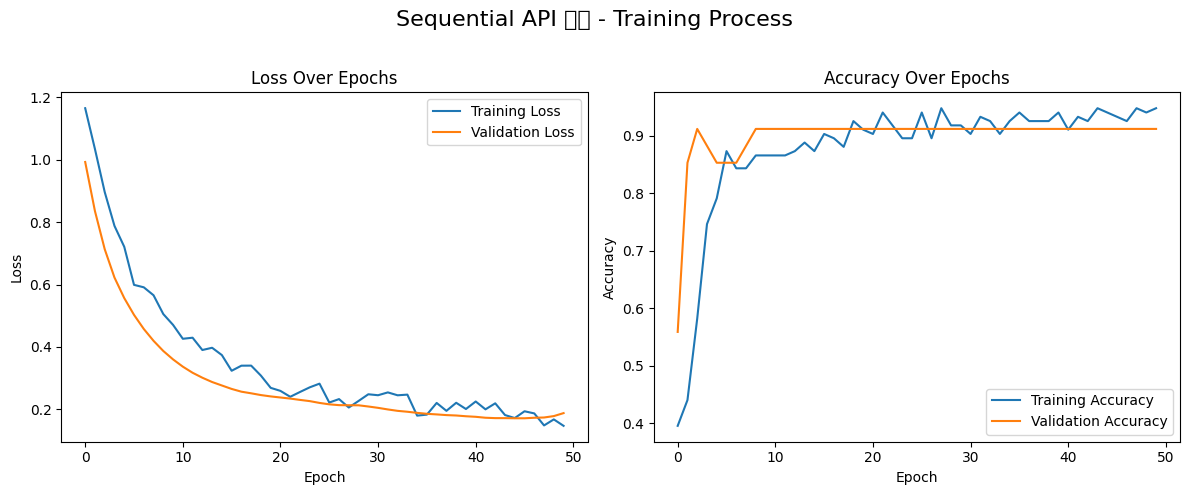


Sequential API 모델 - 최종 테스트 결과:
  테스트 손실: 0.3152
  테스트 정확도: 0.8810

Sequential API 모델 - 평가 지표:
  혼동 행렬:
[[ 9  3  2]
 [ 0 14  0]
 [ 0  0 14]]
  F1 점수 (weighted): 0.8731
  정밀도 (weighted): 0.8995
  재현율 (weighted) / 민감도: 0.8810


In [115]:
# 모델 1: Sequential API
model_sequential = Sequential() # Sequential 모델 객체 생성
model_sequential.add(Dense(64, activation='relu', input_shape=INPUT_SHAPE)) # 첫 번째 레이어는 input_shape 지정
model_sequential.add(Dropout(0.3))
model_sequential.add(Dense(32, activation='relu'))
model_sequential.add(Dropout(0.3))
model_sequential.add(Dense(NUM_CLASSES, activation='softmax')) # 출력층

history_seq, accuracy_seq, f1_seq = train_evaluate_visualize(model_sequential, "Sequential API 모델", X_train, y_train, X_test, y_test)


--- Functional API 모델 ---


Model: "functional_seed_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,691 (10.51 KB)

 Trainable params: 2,691 (10.51 KB)

 Non-trainable params: 0 (0.00 B)

<ipython-input-114-00f8f4ec7d4f>:36: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
<ipython-input-114-00f8f4ec7d4f>:36: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


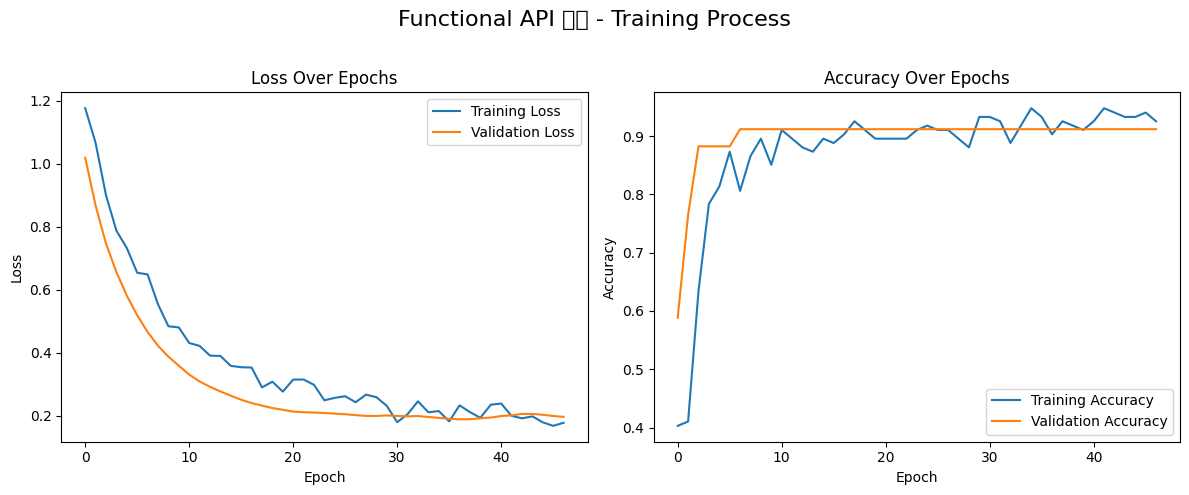


Functional API 모델 - 최종 테스트 결과:
  테스트 손실: 0.2788
  테스트 정확도: 0.8333

Functional API 모델 - 평가 지표:
  혼동 행렬:
[[ 7  3  4]
 [ 0 14  0]
 [ 0  0 14]]
  F1 점수 (weighted): 0.8150
  정밀도 (weighted): 0.8671
  재현율 (weighted) / 민감도: 0.8333


In [116]:
# 모델 2: Functional API
inputs = Input(shape=INPUT_SHAPE, name='input_layer') # name은 선택사항

# 첫 번째 은닉층: 입력 레이어(inputs)의 출력을 받아 처리
x = Dense(64, activation='relu', name='hidden_layer_1')(inputs)
x = Dropout(0.3, name='dropout_1')(x)

# 두 번째 은닉층: 이전 레이어(x)의 출력을 받아 처리
x = Dense(32, activation='relu', name='hidden_layer_2')(x)
x = Dropout(0.3, name='dropout_2')(x)

# 출력 레이어: 클래스 수에 맞게 유닛 수 설정 및 softmax 활성화 함수 사용
outputs = Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)

# Functional API 모델 생성: 입력과 최종 출력을 지정
model_functional = Model(inputs=inputs, outputs=outputs, name='functional_seed_classifier')

history_func, accuracy_func, f1_func = train_evaluate_visualize(model_functional, "Functional API 모델", X_train, y_train, X_test, y_test)


--- Subclassed API 모델 ---


Model: "subclassed_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

<ipython-input-114-00f8f4ec7d4f>:36: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
<ipython-input-114-00f8f4ec7d4f>:36: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


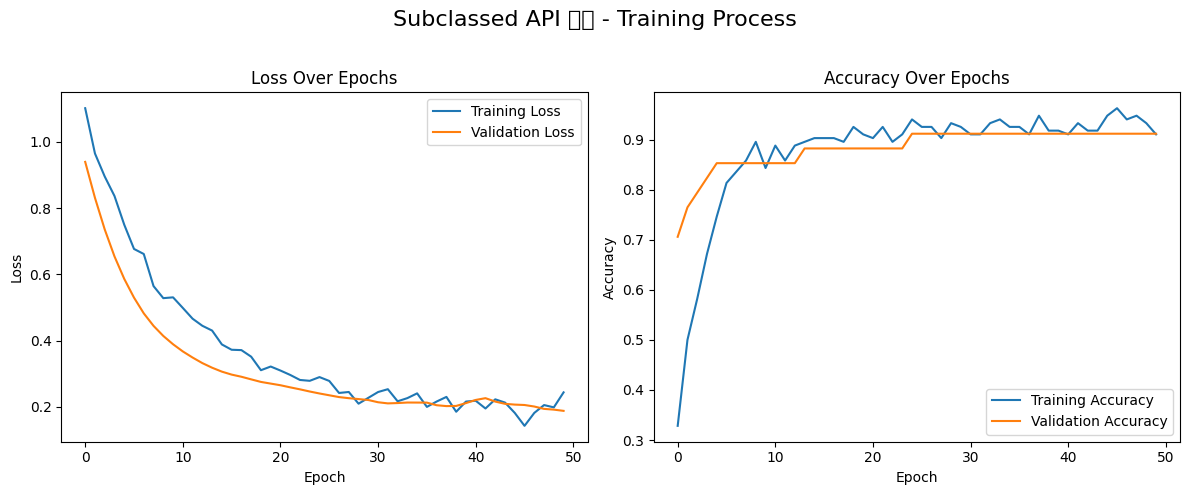


Subclassed API 모델 - 최종 테스트 결과:
  테스트 손실: 0.3312
  테스트 정확도: 0.8571

Subclassed API 모델 - 평가 지표:
  혼동 행렬:
[[ 8  3  3]
 [ 0 14  0]
 [ 0  0 14]]
  F1 점수 (weighted): 0.8446
  정밀도 (weighted): 0.8824
  재현율 (weighted) / 민감도: 0.8571

--- 최종 결과 요약 ---
Sequential API 모델 정확도: 0.8810
Functional API 모델 정확도: 0.8333
Subclassed API 모델 정확도: 0.8571


In [117]:
# 모델 3: Model Subclassing
class SubclassedModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(SubclassedModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(0.3)
        self.dense2 = tf.keras.layers.Dense(32, activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(0.3)
        self.output_dense = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False): # training 인자는 Dropout 등에 필요
        x = self.dense1(inputs)
        if training: # 훈련 시에만 Dropout 활성화
            x = self.dropout1(x, training=training)
        x = self.dense2(x)
        if training:
            x = self.dropout2(x, training=training)
        return self.output_dense(x)

model_subclassed = SubclassedModel(num_classes=NUM_CLASSES)

history_sub, accuracy_sub, f1_sub = train_evaluate_visualize(model_subclassed, "Subclassed API 모델", X_train, y_train, X_test, y_test)

print("\n--- 최종 결과 요약 ---")
print(f"Sequential API 모델 정확도: {accuracy_seq:.4f}")
print(f"Functional API 모델 정확도: {accuracy_func:.4f}")
print(f"Subclassed API 모델 정확도: {accuracy_sub:.4f}")